# Sample weighting(样本加权)

In [1]:
%matplotlib inline
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows",150)
set_option('display.width', 200)
import seaborn as sns

import math
import senutil as sen
# import tensorflow as tf
from pygame import mixer

pygame 2.1.2 (SDL 2.0.18, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
input_vectors = ["DT"]

In [3]:
# Define the curve will be processed定义要处理的曲线
element_name = "DTXX"
paly_music = True

# Data Loading(数据读取)

In [4]:
train_data_path = '../data/exp_curve_reconstract/exp_1/train/QSK/'
filename_AB = 'GY1_R_0.1250m_QSK_2107m-2587m.csv'
train_file_path = os.path.join(train_data_path,filename_AB)
print(train_file_path)

../data/exp_curve_reconstract/exp_1/train/QSK/GY1_R_0.1250m_QSK_2107m-2587m.csv


In [5]:
test_data_path = '../data/exp_curve_reconstract/exp_1/test/QSK/'
filename_A = 'C21_R_ 0.1250m_QSK_1260m-1668m.csv'
test_file_path = os.path.join(test_data_path,filename_A)
print(test_file_path)

../data/exp_curve_reconstract/exp_1/test/QSK/C21_R_ 0.1250m_QSK_1260m-1668m.csv


In [6]:
# filename = 'data.csv'
# 读取A、B部分共有数据
AB = pd.read_csv(train_file_path,engine='python',encoding='GBK')
A = pd.read_csv(test_file_path,engine='python',encoding='GBK')

In [7]:
inputX = AB[input_vectors]
inputX,inputX.shape

(             DT
 0     82.196225
 1     81.984576
 2     81.677681
 3     81.509332
 4     81.742845
 ...         ...
 3836  86.894184
 3837  85.568864
 3838  81.355412
 3839  76.638988
 3840  72.828514
 
 [3841 rows x 1 columns],
 (3841, 1))

In [8]:
inputY = A[input_vectors]
inputY,inputY.shape

(              DT
 0      97.479675
 1      96.227397
 2      98.291990
 3     102.595468
 4     106.571764
 ...          ...
 3180  101.874630
 3181  103.317856
 3182  104.394786
 3183  103.615636
 3184  104.755236
 
 [3185 rows x 1 columns],
 (3185, 1))

In [9]:
# 设置输入曲线范围,由于取了对数，所以RD和RS设置下限-1
# setting the range of curves
DT = [40,200]
AC = [140,300]
CNL = [-0.8,70]
DEN = [1,3]
GR = [0,350]
RD = [0,5]
RS = [0,5]
RLLD = [0,5]
RLLS = [0,5]

In [10]:
u_log = {"DT":DT,"AC": AC,"CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"RLLD": RLLD, "RLLS": RLLS}

In [11]:
u_log_name = []
# 关键在于 input_vectors''
for i in input_vectors:
    u_log_name.append(u_log[i])
    
u_log_name

[[40, 200]]

In [12]:
x = sen.zero_one_scaler(inputX,u_log_name)
y = sen.zero_one_scaler(inputY,u_log_name)

In [13]:
X = np.array(x)
Y = np.array(y)

# Setting DTW Matrix(设置DTW (Dynamic Time Warping)矩阵)

In [14]:
distances = np.zeros((len(Y), len(X)))
for i in range(len(Y)):
    for j in range(len(X)):
        distances[i,j] = (X[j]-Y[i])**2 
distances

array([[0.00912437, 0.00937883, 0.00975402, ..., 0.01015593, 0.01696618,
        0.02373749],
       [0.00769038, 0.00792414, 0.00826931, ..., 0.00863968, 0.01498851,
        0.02138702],
       [0.01012006, 0.01038796, 0.01078263, ..., 0.01120499, 0.01831455,
        0.02532768],
       ...,
       [0.01924907, 0.01961787, 0.02015886, ..., 0.02073487, 0.03009314,
        0.03892303],
       [0.01792153, 0.01827745, 0.01879976, ..., 0.01935615, 0.02842733,
        0.03702527],
       [0.01987926, 0.02025402, 0.02080365, ..., 0.02138874, 0.03087982,
        0.03981701]])

In [15]:
distances.shape

(3185, 3841)

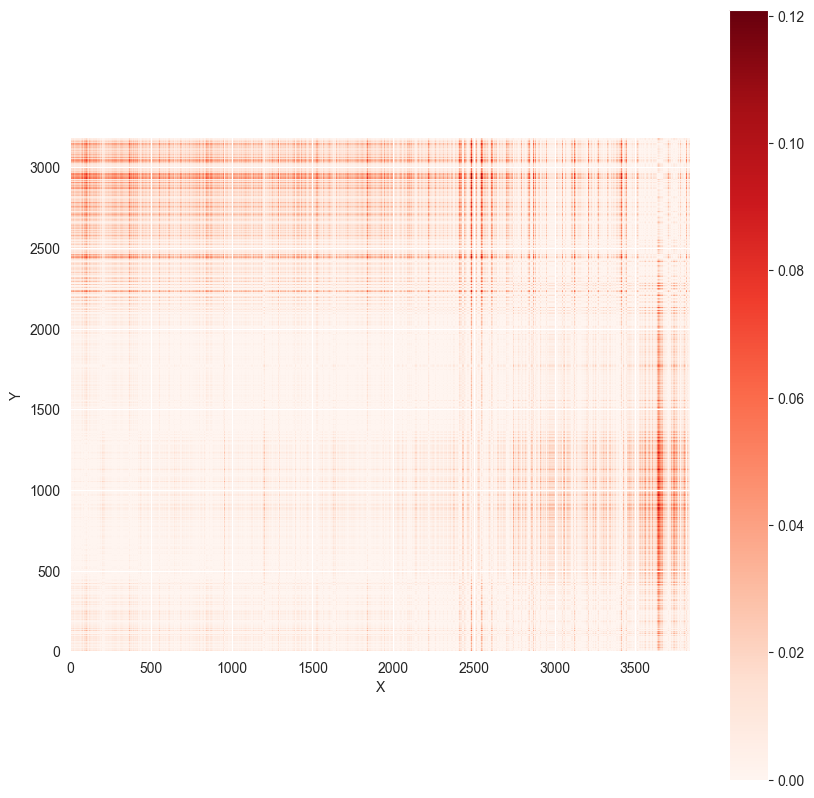

In [16]:
def distance_cost_plot(distances):
    plt.figure(figsize=(10,10))
    plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()#倒转y轴，让它与x轴的都从左下角开始
    plt.xlabel("X")
    plt.ylabel("Y")
#    plt.grid()
    plt.colorbar()
distance_cost_plot(distances)

# Obtain the distance accumulation matrix(得出距离累计矩阵)

In [17]:
accumulated_cost = np.zeros((len(Y), len(X)))

In [18]:
accumulated_cost[0,0] = distances[0,0]
accumulated_cost

array([[0.00912437, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
for i in range(1, len(Y)):
    for j in range(1, len(X)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]

In [20]:
accumulated_cost

array([[0.00912437, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00792414, 0.00826931, ..., 0.00863968, 0.01498851,
        0.02138702],
       [0.        , 0.01038796, 0.01870677, ..., 0.01564266, 0.02695424,
        0.04031619],
       ...,
       [0.        , 0.01961787, 0.03793655, ..., 1.31630411, 1.34120143,
        1.37384144],
       [0.        , 0.01827745, 0.03707721, ..., 1.31928795, 1.34473143,
        1.3782267 ],
       [0.        , 0.02025402, 0.03908111, ..., 1.32385495, 1.35016777,
        1.38454845]])

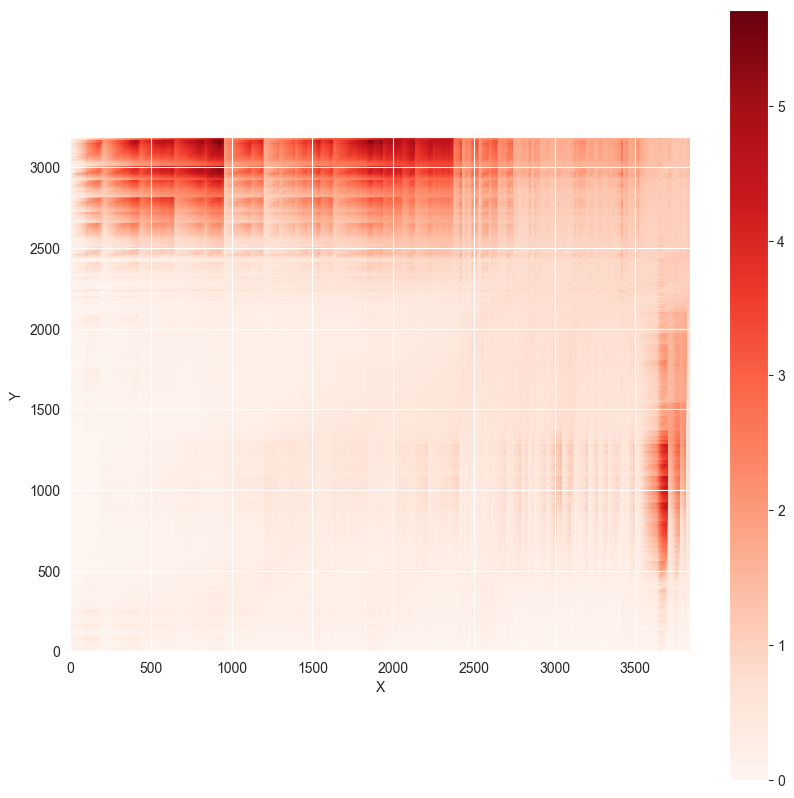

In [21]:
distance_cost_plot(accumulated_cost)
# 最佳路径已经清晰地显示在了累积距离矩阵之中，就是图中颜色最淡的方块
# The optimal path has been clearly displayed in the cumulative distance matrix,
# which is the lightest colored block in the figure

# The method of backtracking to find the best path(回溯的方法找回最佳路径)

In [22]:
path = [[len(X)-1, len(Y)-1]]
i = len(Y)-1
j = len(X)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1#来自于左边
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j-1#来自于下边
        else:
            i = i - 1#来自于左下边
            j= j- 1
    path.append([j, i])
path.append([0,0])

In [23]:
path

[[3840, 3184],
 [3839, 3183],
 [3838, 3182],
 [3837, 3181],
 [3836, 3180],
 [3835, 3179],
 [3834, 3178],
 [3833, 3178],
 [3832, 3178],
 [3831, 3178],
 [3830, 3178],
 [3829, 3178],
 [3828, 3178],
 [3827, 3178],
 [3826, 3178],
 [3825, 3177],
 [3824, 3177],
 [3823, 3177],
 [3822, 3177],
 [3821, 3177],
 [3820, 3177],
 [3819, 3177],
 [3818, 3177],
 [3817, 3176],
 [3816, 3176],
 [3815, 3176],
 [3814, 3176],
 [3813, 3176],
 [3812, 3176],
 [3811, 3176],
 [3810, 3176],
 [3809, 3176],
 [3808, 3175],
 [3808, 3174],
 [3808, 3173],
 [3808, 3172],
 [3808, 3171],
 [3808, 3170],
 [3808, 3169],
 [3808, 3168],
 [3807, 3167],
 [3807, 3166],
 [3807, 3165],
 [3806, 3164],
 [3806, 3163],
 [3806, 3162],
 [3805, 3161],
 [3805, 3160],
 [3805, 3159],
 [3805, 3158],
 [3805, 3157],
 [3805, 3156],
 [3805, 3155],
 [3805, 3154],
 [3805, 3153],
 [3805, 3152],
 [3805, 3151],
 [3805, 3150],
 [3805, 3149],
 [3805, 3148],
 [3804, 3147],
 [3803, 3146],
 [3803, 3145],
 [3803, 3144],
 [3803, 3143],
 [3803, 3142],
 [3803, 31

In [24]:
accumulated_cost

array([[0.00912437, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00792414, 0.00826931, ..., 0.00863968, 0.01498851,
        0.02138702],
       [0.        , 0.01038796, 0.01870677, ..., 0.01564266, 0.02695424,
        0.04031619],
       ...,
       [0.        , 0.01961787, 0.03793655, ..., 1.31630411, 1.34120143,
        1.37384144],
       [0.        , 0.01827745, 0.03707721, ..., 1.31928795, 1.34473143,
        1.3782267 ],
       [0.        , 0.02025402, 0.03908111, ..., 1.32385495, 1.35016777,
        1.38454845]])

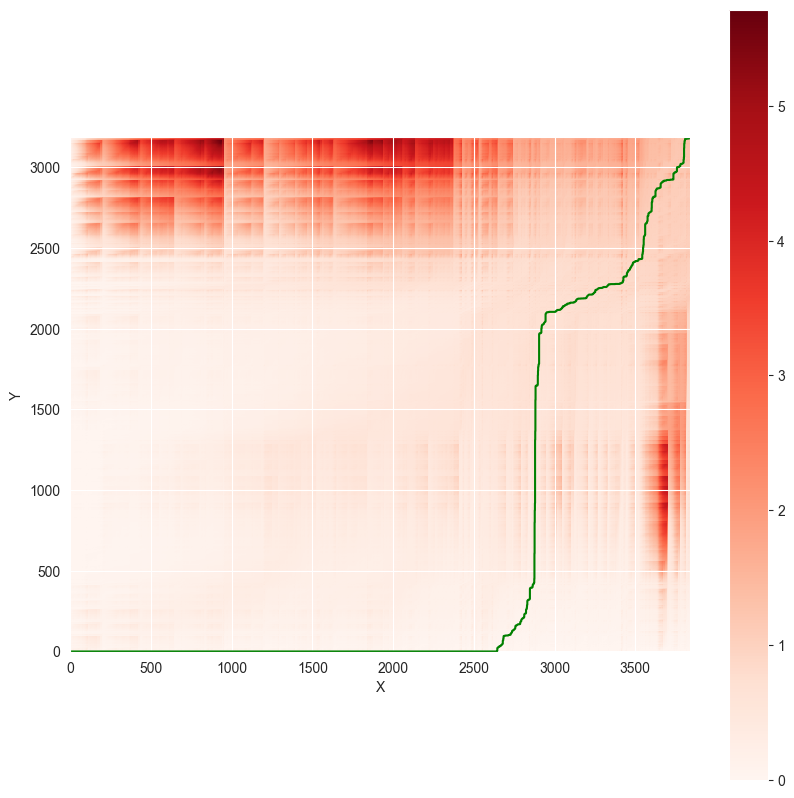

In [25]:
path_x = [point[0] for point in path]
path_y = [point[1] for point in path]
distance_cost_plot(accumulated_cost)
plt.plot(path_x, path_y,color = 'green')

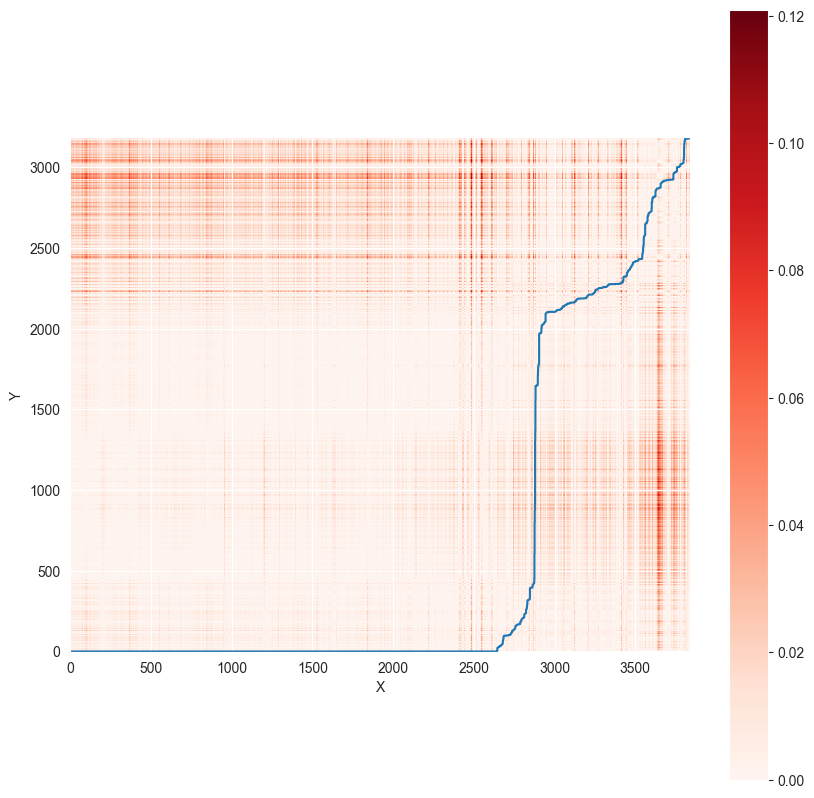

In [26]:
distance_cost_plot(distances)
plt.plot(path_x, path_y)

# Determine weight factors(确定权重因子)

In [27]:
distances.shape,len(path_x),len(path_y),accumulated_cost[-1,-1]

((3185, 3841), 3853, 3853, 1.3845484459280106)

In [28]:
use_path = np.array(path)
use_path

array([[3840, 3184],
       [3839, 3183],
       [3838, 3182],
       ...,
       [2642,    1],
       [2642,    0],
       [   0,    0]])

In [29]:
use_path.shape

(3853, 2)

In [30]:
dis_list =[]
for i in range(len(use_path)):
    a = distances[use_path[i][1],use_path[i][0]]
    dis_list.append(a)
print(len(dis_list))

3853


In [31]:
np.mean(dis_list),np.var(dis_list),np.median(dis_list)

(0.0003617285175178506, 1.1702166586728985e-06, 8.961258340295805e-05)

In [32]:
a ,b = np.split(use_path,2,axis=1)

In [33]:
a,b

(array([[3840],
        [3839],
        [3838],
        ...,
        [2642],
        [2642],
        [   0]]),
 array([[3184],
        [3183],
        [3182],
        ...,
        [   1],
        [   0],
        [   0]]))

In [34]:
# 返回实际起作用的序列索引
location_x, dis_list_location = np.unique(a,return_index=True)

In [35]:
len(location_x),location_x,dis_list_location

(1200,
 array([   0, 2642, 2643, ..., 3838, 3839, 3840]),
 array([3852, 3850, 3849, ...,    2,    1,    0], dtype=int64))

## Set average similarity as overall weight(平均相似度设置为总体权重)

In [36]:
w = accumulated_cost[-1,-1]
average_weight = math.exp(-w)
average_weight

0.2504368600472962

In [37]:
sample_weight = np.full((len(X)),average_weight)

## Set specific sample weights based on sequence correspondence(根据序列对应关系设定特定样本权重)

In [38]:
# sample_weight = np.zeros(len(X))
for i in range(len(location_x)):
    w_loc = location_x[i]
    w_value = dis_list[dis_list_location[i]]
    # print(w_loc,w_value)
    weight = math.exp(-w_value)
    sample_weight[w_loc] = weight

In [39]:
np.set_printoptions(threshold=500)
sample_weight[-100:]
# sample_weight

array([0.99998649, 0.99999953, 0.99986555, 0.99998709, 0.99997033,
       0.99999073, 0.99976525, 0.99943422, 0.99932983, 0.99948969,
       0.99977372, 0.9999746 , 0.99999319, 0.99999295, 0.99999734,
       0.99998945, 0.99998627, 0.99998188, 0.99999072, 0.99993461,
       0.99944144, 0.99878451, 0.99896226, 0.99936041, 0.99973352,
       0.99999891, 0.99946631, 0.99836163, 0.99852859, 0.99973462,
       0.99998614, 0.99999957, 0.9996936 , 0.99896252, 0.99808478,
       0.99869054, 0.99967193, 0.99995916, 0.9999638 , 0.99999467,
       0.99999646, 0.99999981, 0.9999999 , 0.99998807, 0.9999387 ,
       0.99992434, 0.99999569, 0.99999276, 0.99997069, 0.99996151,
       0.99998998, 0.99999306, 0.99999724, 0.99998546, 0.99996704,
       0.99999956, 0.99997738, 0.99999335, 0.99953508, 0.9998306 ,
       0.99999549, 0.99999904, 0.99963892, 0.99999272, 0.99997971,
       0.99997561, 0.99999451, 0.99997737, 0.9989244 , 0.99634218,
       0.99324057, 0.99060435, 0.99073734, 0.99397467, 0.99524

In [40]:
# 效果一般
def cal_dtw_distance(ts_a, ts_b):
    """Returns the DTW similarity distance between two 2-D
    timeseries numpy arrays.

    Arguments
    ---------
    ts_a, ts_b : array of shape [n_samples, n_timepoints]
        Two arrays containing n_samples of timeseries data
        whose DTW distance between each sample of A and B
        will be compared

    d : DistanceMetric object (default = abs(x-y))
        the distance measure used for A_i - B_j in the
        DTW dynamic programming function

    Returns
    -------
    DTW distance between A and B
    """
    d=lambda x, y: abs(x - y)
#     d=lambda x, y: abs(x - y)**2 
    max_warping_window = 10000

    # Create cost matrix via broadcasting with large int
    ts_a, ts_b = np.array(ts_a), np.array(ts_b)
    M, N = len(ts_a), len(ts_b)
    cost = sys.maxsize * np.ones((M, N))

    # Initialize the first row and column
    cost[0, 0] = d(ts_a[0], ts_b[0])
    for i in range(1, M):
        cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])

    # Populate rest of cost matrix within window
    for i in range(1, M):
        for j in range(max(1, i - max_warping_window),
                       min(N, i + max_warping_window)):
            choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
            cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

    # Return DTW distance given window
    return cost[-1, -1]

In [41]:
# dtw_ab = cal_dtw_distance(X, Y)
# dtw_ab

In [42]:
# average_weight_dtw_ab = math.exp(-dtw_ab)
# average_weight_dtw_ab

In [43]:
# https://blog.csdn.net/xsdxs/article/details/86648605
# 效果不好，计算相似度
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind': float_formatter})


def TimeSeriesSimilarityImprove(s1, s2):
    # 取较大的标准差
    sdt = np.std(s1, ddof=1) if np.std(s1, ddof=1) > np.std(s2, ddof=1) else np.std(s2, ddof=1)
    # print("两个序列最大标准差:" + str(sdt))
    l1 = len(s1)
    l2 = len(s2)
    paths = np.full((l1 + 1, l2 + 1), np.inf)  # 全部赋予无穷大
    sub_matrix = np.full((l1, l2), 0)  # 全部赋予0
    max_sub_len = 0

    paths[0, 0] = 0
    for i in range(l1):
        for j in range(l2):
            d = s1[i] - s2[j]
            cost = d ** 2
            paths[i + 1, j + 1] = cost + min(paths[i, j + 1], paths[i + 1, j], paths[i, j])
            if np.abs(s1[i] - s2[j]) < sdt:
                if i == 0 or j == 0:
                    sub_matrix[i][j] = 1
                else:
                    sub_matrix[i][j] = sub_matrix[i - 1][j - 1] + 1
                    max_sub_len = sub_matrix[i][j] if sub_matrix[i][j] > max_sub_len else max_sub_len

    paths = np.sqrt(paths)
    s = paths[l1, l2]
    return s, paths.T, [max_sub_len]


def calculate_attenuate_weight(seqLen1, seqLen2, com_ls):
    weight = 0
    for comlen in com_ls:
        weight = weight + comlen / seqLen1 * comlen / seqLen2
    return 1 - weight

In [44]:
# distance12, paths12, max_sub12 = TimeSeriesSimilarityImprove(X, Y)
# # distance13, paths13, max_sub13 = TimeSeriesSimilarityImprove(s1, s3)

# print("更新前s1和s2距离：" + str(distance12))
# #print("更新前s1和s3距离：" + str(distance13))

#     # 衰减系数
# weight12 = calculate_attenuate_weight(len(X), len(Y), max_sub12)
# #weight13 = calculate_attenuate_weight(len(s1), len(s3), max_sub13)

# # 更新距离
# print("更新后s1和s2距离：" + str(distance12 * weight12))
# #print("更新后s1和s3距离：" + str(distance13 * weight13))
# 更新前s1和s2距离：1.5347910807564598
# 更新后s1和s2距离：1.5251134490150273


In [45]:
# sample_weight

In [46]:
add_coloum = pd.DataFrame(sample_weight,columns=['sample_weight'],index=AB.index)
add_coloum

,sample_weight
0,0.990917
1,0.250437
2,0.250437
3,0.250437
4,0.250437
...,...
3836,0.991272
3837,0.987770
3838,0.979479
3839,0.971973


D:\Program Files\Python310\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


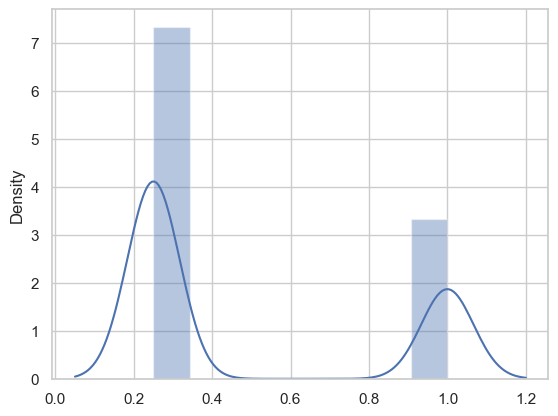

In [47]:
sns.set(style='whitegrid', context='notebook')   #style控制默认样式,context控制着默认的画幅大小
# sns.pairplot(AB, size=5)
# sns.pairplot(analy_data, size=3)
# 保存结果图
fig = sns.distplot(add_coloum,hist=True,kde=True)

## Does not match the average similarity calculated based on DTW（不跟据DTW计算得到的平均相似度）

In [48]:
corr_pre_data = pd.concat([inputX,inputY],axis=1)
corr_pre_data.index

RangeIndex(start=0, stop=3841, step=1)

In [49]:
corr_pre_data.columns=['DT','DT_New']

In [50]:
if len(inputX) >= len(inputY):
    fill_value = np.mean(inputX)
else:
    fill_value = np.mean(inputY)

# 下面式子效果不好
## fill_value = (np.median(inputX) + np.median(inputY))/2.0

In [51]:
fill_value

95.11906109815152

In [52]:
corr_data = corr_pre_data.fillna(fill_value)

In [53]:
corr_data

,DT,DT_New
0,82.196225,97.479675
1,81.984576,96.227397
2,81.677681,98.291990
3,81.509332,102.595468
4,81.742845,106.571764
...,...,...
3836,86.894184,95.119061
3837,85.568864,95.119061
3838,81.355412,95.119061
3839,76.638988,95.119061


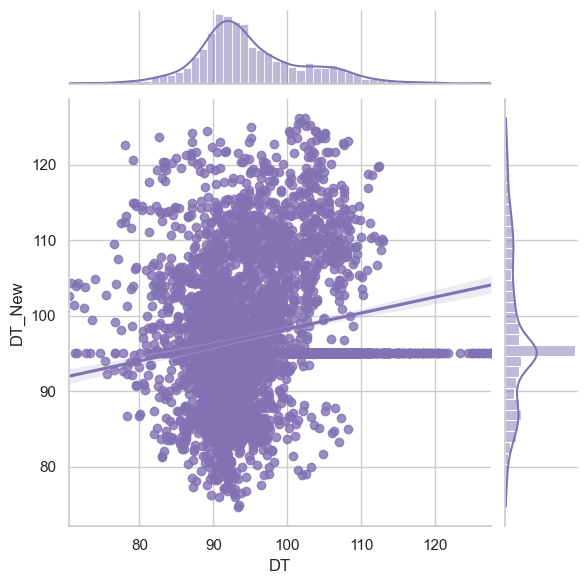

In [54]:
sns.set(style='whitegrid', context='notebook')   #style控制默认样式,context控制着默认的画幅大小
# sns.pairplot(AB, size=5)
# sns.pairplot(analy_data, size=3)
# 保存结果图
fig = sns.jointplot(x = "DT",y = "DT_New", data=corr_data,
                  kind="reg", truncate=True,
                  color="m", height=6)
# fig = plt.scatter(corr_data.loc[input_vectors],corr_data.loc[input_vectors + '_New'])

D:\Program Files\Python310\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


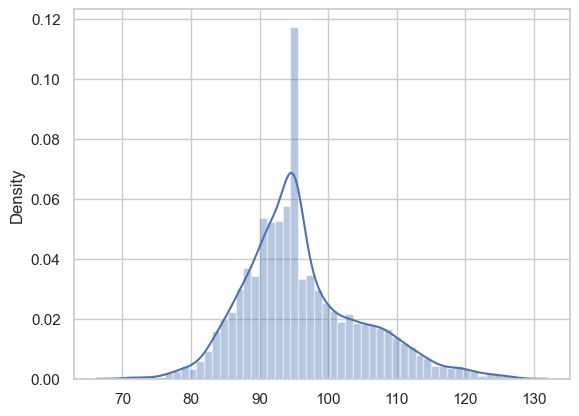

In [55]:
fig = sns.distplot(corr_data)

In [56]:
corr_data.corr()

,DT,DT_New
DT,1.000000,0.169118
DT_New,0.169118,1.000000


<Axes: >

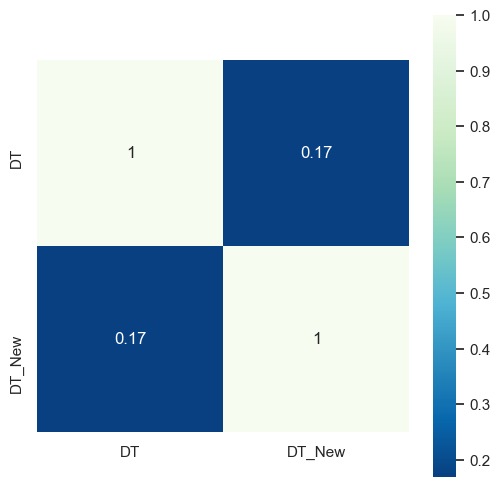

In [57]:
# corr = AB.corr()
plt.figure(figsize=(6,6))
corr_data_heat = corr_data.corr()
# 相关度热力图
sns.heatmap(corr_data_heat, cmap='GnBu_r', square=True, annot=True)
# plt.savefig('heatmap.png')

# Weight factors and well logging data storage（重因子和测井数据保存）

In [58]:
new_data = pd.concat([AB,add_coloum],axis=1)

D:\Program Files\Python310\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


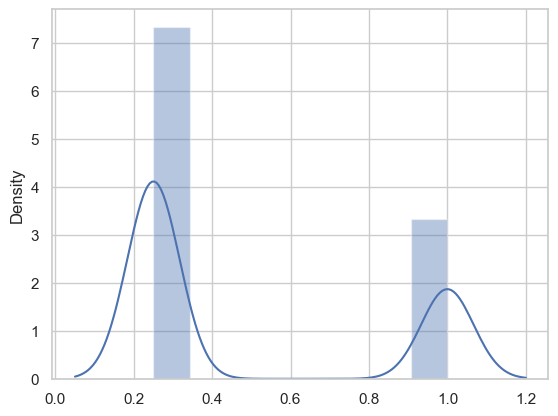

In [59]:
fig = sns.distplot(add_coloum)

In [60]:
new_data

,DEPTH,DT,CNL,DEN,GR,RD,RS,DTXX,sample_weight
0,2107.000,82.196225,17.3,2.451,120,4.91,5.11,168.247598,0.990917
1,2107.125,81.984576,16.9,2.444,118,5.18,5.37,166.368776,0.250437
2,2107.250,81.677681,16.3,2.437,116,5.40,5.60,165.172409,0.250437
3,2107.375,81.509332,15.8,2.435,114,5.55,5.76,164.581235,0.250437
4,2107.500,81.742845,15.7,2.448,116,5.57,5.82,164.762338,0.250437
...,...,...,...,...,...,...,...,...,...
3836,2586.500,86.894184,15.4,2.652,138,5.31,6.30,169.218485,0.991272
3837,2586.625,85.568864,14.9,2.651,136,5.35,6.32,162.964982,0.987770
3838,2586.750,81.355412,14.0,2.646,135,5.59,6.52,156.272841,0.979479
3839,2586.875,76.638988,12.5,2.645,127,6.50,7.39,149.232910,0.971973


In [61]:
result_csv_name = filename_AB.split(".csv")[0] + "_for_" + filename_A.split(".csv")[0] +  "_add_sample_weight" + ".csv"
result_csv_name

'GY1_R_0.1250m_QSK_2107m-2587m_for_C21_R_ 0.1250m_QSK_1260m-1668m_add_sample_weight.csv'

In [62]:
new_data.to_csv(train_data_path + result_csv_name,mode='w',index=None,header=True)